# Mask Detection (CNN - EfficientNetB0)

![](https://res.cloudinary.com/hilnmyskv/image/upload/q_70,f_auto/v1681989722/Algolia_com_Blog_assets/Featured_images/ai/whats-a-convolutional-neural-network-and-how-is-it-used-for-image-recognition-in-search/qcnr7cgpkgwvgsqgdx0m.jpg)

### **Contructing a simple CNN for mask detection**

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import AUC

import cv2
from align_faces import warp_and_crop_face, get_reference_facial_points
from mtcnn.detector import MtcnnDetector
from tensorflow.keras.models import load_model

from sklearn.metrics import roc_auc_score


2023-12-17 01:28:27.377561: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Processing

In [4]:
#Data paths
dataset = "dataset"
imagePaths = list(paths.list_images(dataset))

Data structure
```
dataset 
└───with mask <- Pictures with mask
│       1.jpg
│       ...
└───without mask <- Pictures without mask
        2.jpg
        ...         
```

In [46]:
data = []
labels = []

# 17998 pictures in total
for i in imagePaths[-8999:] + imagePaths[:8999]:
    
    label = i.split(os.path.sep)[-2]
    labels.append(label)
    
    image = load_img(i, target_size = (224, 224)) 
    image = img_to_array(image)
    data.append(image)
    
data = np.array(data,dtype="float32")
labels = np.array(labels)

/Users/dragonsave/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
print(data.shape)
print(labels.shape)

(17998, 224, 224, 3)
(17998,)


In [10]:
# Convert to binary labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Converts a class vector (integers) to binary class matrix
labels = to_categorical(labels)

In [12]:
# Slpiting data into train/validation/test set with portion 5/1/4 respectively
train_X, test_X, train_Y, test_Y = train_test_split(data, labels, test_size = 0.5, stratify = labels, random_state = 0)
val_X, test_X, val_Y, test_Y = train_test_split(test_X, test_Y, test_size = 0.8, stratify = test_Y, random_state = 0)

In [13]:
# Print shape of data set
print("Train_X:",train_X.shape)
print("Train Y:", train_Y.shape)
print("Test_X:",test_X.shape)
print("Test_Y:",test_Y.shape)
print("Val_X:",val_X.shape)
print("Val_Y:",val_Y.shape)

Train_X: (8999, 224, 224, 3)
Train Y: (8999, 2)
Test_X: (7200, 224, 224, 3)
Test_Y: (7200, 2)
Val_X: (1799, 224, 224, 3)
Val_Y: (1799, 2)


# Model Construction

## Agumentation

Data augmentation in the context of Convolutional Neural Networks (CNNs) refers to the process of creating variations of the training dataset to improve the model"s generalization capabilities. These techniques can be applied randomly and in combinations to each image in the training set, generating a much larger and more varied set of training samples. 


In [16]:
# Setting augmentation
aug = ImageDataGenerator(
    rotation_range=15,  # Slightly reduced the rotation range
    zoom_range=0.10,  # Slightly reduced the zoom range
    width_shift_range=0.1,  # Slightly reduced the shift ranges
    height_shift_range=0.1,
    shear_range=0.1,  # Reduced the shear range
    horizontal_flip=True,  # Assuming horizontal flipping is contextually appropriate
    fill_mode="nearest",
    brightness_range=[0.8, 1.2]  # Adding brightness range for variability in lighting conditions
)


## EfficientNetBO

EfficientNet is a family of convolutional neural network (CNN) architectures and scaling methods that systematically scale all dimensions of the network—depth, width, and resolution—with a set of fixed scaling coefficients. EfficientNetB0 was introduced by Mingxing Tan and Quoc V. Le in their paper "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks."

In [18]:
# Using efficientNetBO model as based model
baseModel = tf.keras.applications.EfficientNetB0(include_top = False, weights="imagenet", 
                                                 input_tensor=Input(shape=(224,224,3)))

baseModel

Setting **include_top=False** to modifying the head of the model

AveragePooling2D -> Flatten -> Dense -> Dropout -> Dense

In [20]:
# Modifying head of the model
headModel = baseModel.output
headModel = layers.GlobalAveragePooling2D(name = "Global_average_pooling")(headModel)
headModel = layers.Flatten(name = "Flatten")(headModel)
headModel = layers.Dense(units=128, activation="relu")(headModel)
headModel = layers.Dropout(rate=0.5)(headModel)

# Unites is equals 2 because we only have 2 possible outputs
# Softmax activation returns a vector of probabilities, where the probabilities of each value are proportional
headModel = layers.Dense(units=2, activation="softmax")(headModel)

# Model setting
model = tf.keras.Model(inputs = baseModel.input, outputs = headModel)

In [22]:
for layer in baseModel.layers:
    layer.trainable= False

## Trainning model

In [92]:
# Creating validation data
validation_data = (val_X, val_Y)
validation_data[0].shape

(1799, 224, 224, 3)

In [28]:
learning_rate = 0.001
Epochs = 10
BS = 40

# Define the optimizer with the specified learning rate and decay
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=learning_rate/Epochs)

# Compile the model with binary cross-entropy loss and AUC metric
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=[tf.keras.metrics.AUC()])

# Train the model
H = model.fit(
    aug.flow(train_X, train_Y, batch_size=BS),  # Use data augmentation during training
    steps_per_epoch=len(train_X)//BS,
    validation_data=(val_X, val_Y),
    validation_steps=len(val_X)//BS,
    epochs=Epochs
)

# Save the trained model
model.save_weights("efficientnet66.model")


Epoch 1/10
224/224 [==============================] - 306s 1s/step - loss: 0.0560 - auc_1: 0.9963 - val_loss: 0.0197 - val_auc_1: 0.9988
Epoch 2/10
224/224 [==============================] - 298s 1s/step - loss: 0.0332 - auc_1: 0.9972 - val_loss: 0.0140 - val_auc_1: 0.9999
Epoch 3/10
224/224 [==============================] - 299s 1s/step - loss: 0.0240 - auc_1: 0.9980 - val_loss: 0.0130 - val_auc_1: 0.9994
Epoch 4/10
224/224 [==============================] - 302s 1s/step - loss: 0.0212 - auc_1: 0.9985 - val_loss: 0.0140 - val_auc_1: 0.9993
Epoch 5/10
224/224 [==============================] - 306s 1s/step - loss: 0.0191 - auc_1: 0.9986 - val_loss: 0.0108 - val_auc_1: 1.0000
Epoch 6/10
224/224 [==============================] - 301s 1s/step - loss: 0.0153 - auc_1: 0.9988 - val_loss: 0.0082 - val_auc_1: 0.9989
Epoch 7/10
224/224 [==============================] - 305s 1s/step - loss: 0.0118 - auc_1: 0.9994 - val_loss: 0.0066 - val_auc_1: 0.9994
Epoch 8/10
224/224 [=====================

In [99]:
# Training history of model
H.history

{'loss': [0.055955760180950165,
  0.03317251056432724,
  0.02402639202773571,
  0.021201979368925095,
  0.019053718075156212,
  0.015262706205248833,
  0.011759116314351559,
  0.013994107954204082,
  0.010542897507548332,
  0.010847607627511024],
 'auc_1': [0.9962721467018127,
  0.9972269535064697,
  0.9980413913726807,
  0.9985059499740601,
  0.9986370205879211,
  0.9988057613372803,
  0.9993942975997925,
  0.9988283514976501,
  0.9995115399360657,
  0.9990725517272949],
 'val_loss': [0.01974758692085743,
  0.013956439681351185,
  0.012958125211298466,
  0.013968165963888168,
  0.01081464346498251,
  0.008171770721673965,
  0.006605189293622971,
  0.008492962457239628,
  0.0112595921382308,
  0.008187736384570599],
 'val_auc_1': [0.9987539649009705,
  0.9999233484268188,
  0.999377965927124,
  0.9993455410003662,
  0.9999508261680603,
  0.9988686442375183,
  0.9994310736656189,
  0.9994255304336548,
  0.9988480806350708,
  0.9988703727722168]}

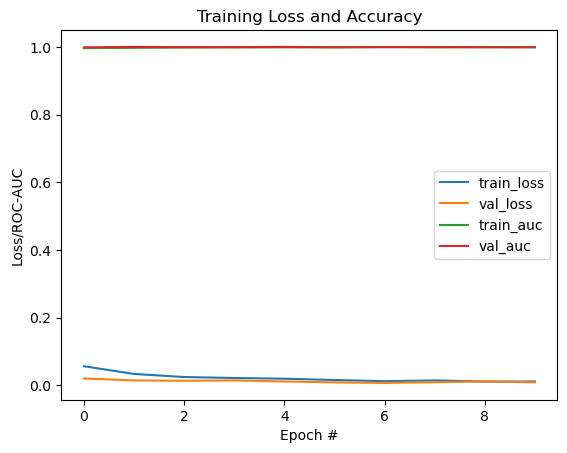

In [102]:
# Drawing the plot

N = Epochs
# Create a new figure
plt.figure()
# Plot the training loss
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
# Plot the validation loss
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
# Plot the training ROC-AUC
plt.plot(np.arange(0, N), H.history["auc_1"], label="train_auc")
# Plot the validation ROC-AUC
plt.plot(np.arange(0, N), H.history["val_auc_1"], label="val_auc")
# Set the title of the plot
plt.title("Training Loss and Accuracy")
# Set the label for the x-axis
plt.xlabel("Epoch #")
# Set the label for the y-axis
plt.ylabel("Loss/ROC-AUC")
# Add a legend to the plot
plt.legend(loc="center right")

# Multi-face detection

Function to detect mask

In [33]:
def mask_detect(image):
    
    img = image.copy()
    (h,w) = img.shape[:2]
    boxes, facxial5points = detector.detect_faces(img)
    for box in boxes:
        (startX,startY,endX,endY)=box[:4].astype("int")

        # Ensure the bounding boxes fall within the dimensions of the frame
        (startX,startY)=(max(0,startX),max(0,startY))
        (endX,endY)=(min(w-1,endX), min(h-1,endY))


        # Extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face=img[startY:endY, startX:endX]
        face=cv2.resize(face,(224,224))

        (mask,withoutMask)=model.predict(face.reshape(1,224,224,3))[0]

        # Determine the class label and color we will use to draw the bounding box and text
        label="Mask" if mask>withoutMask else "No Mask"
        color=(0,255,0) if label=="Mask" else (0,0,255)

        # Include the probability in the label
        label="{}: {:.2f}%".format(label,max(mask,withoutMask)*100)

        # Display the label and bounding boxes
        cv2.putText(img,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        cv2.rectangle(img,(startX,startY),(endX,endY),color,2)
        
    return img

**Green**: With mask

**Red**: Without mask

1/1 [==============================] - 0s 48ms/step


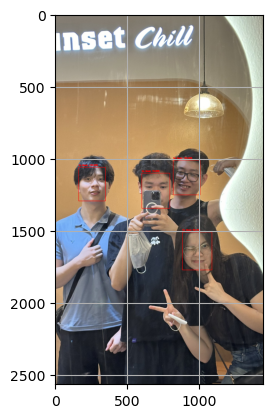

In [149]:
img = cv2.imread("image/z4843279776293_d9ae08bbae96f57845faa8f2444fa4f7.jpg")
img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 53ms/step


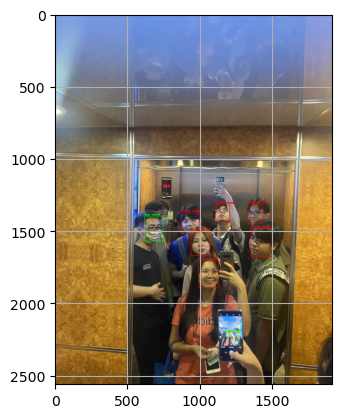

In [143]:
img = cv2.imread("image/z4828646723178_89143f3e2c78541979f6071a20b814f8.jpg")
img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()